In [4]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from src import project_dir

### Compare greedy vs gates diff vs statistical selection

In [44]:
diff_resdirs = {
    'affectiveroad': os.path.join(project_dir, 'saved_logs', 'affectiveroad', 'diff_fs_fcnn___2025.08.04-19.38.27.709'),
    'har': os.path.join(project_dir, 'saved_logs', 'har', 'diff_fs_fcnn___2025.08.05-10.09.20.724'),
    'harth': os.path.join(project_dir, 'saved_logs', 'harth', 'diff_fs_fcnn___2025.08.05-10.55.53.050'),
    'spd': os.path.join(project_dir, 'saved_logs', 'spd', 'diff_fs_fcnn___2025.08.05-09.31.29.362'),
    'stressinnurses': os.path.join(project_dir, 'saved_logs', 'stressinnurses', 'diff_fs_fcnn___2025.08.05-14.54.59.567'),
    'wesad_merged': os.path.join(project_dir, 'saved_logs', 'wesad_merged', 'diff_fs_fcnn___2025.08.05-08.32.55.185'),
}
greedy_resdirs = {
    'affectiveroad': os.path.join(project_dir, 'saved_logs', 'affectiveroad', 'greedy_affroad___2025.08.04-13.01.24.640'),
    'har': os.path.join(project_dir, 'saved_logs', 'har', 'greedy_fs_fcnn___2025.08.05-13.02.44.883'),
    'harth': os.path.join(project_dir, 'saved_logs', 'harth', 'greedy_fs_fcnn___2025.08.05-13.56.38.673'),
    'spd': os.path.join(project_dir, 'saved_logs', 'spd', 'greedy_fs_fcnn___2025.08.04-16.35.20.745'),
    'stressinnurses': os.path.join(project_dir, 'saved_logs', 'stressinnurses', 'greedy_fs_fcnn___2025.08.05-08.31.48.839'),
    'wesad_merged': os.path.join(project_dir, 'saved_logs', 'wesad_merged', 'greedy_fs_fcnn___2025.08.04-18.39.50.101'),
}
statistical_resdirs = {
    'affectiveroad': os.path.join(project_dir, 'saved_logs', 'affectiveroad', 'sota_mlp___2025.08.04-15.32.14.543'),
    'har': os.path.join(project_dir, 'saved_logs', 'har', 'sota_mlp___2025.08.06-10.33.54.390'),
    'spd': os.path.join(project_dir, 'saved_logs', 'spd', 'sota_mlp___2025.08.06-09.41.13.832'),
    'wesad_merged': os.path.join(project_dir, 'saved_logs', 'wesad_merged', 'sota_mlp___2025.08.05-13.51.30.626'),
}

In [45]:
def parse_diff_logfile(filepath):
    data = []
    model_id = None
    pruned_costs = {}

    # Regular expressions
    model_start_re = re.compile(r"Model (\d+) summary:")
    tuned_accuracy_re = re.compile(r"Test accuracy from tuned model number (\d+): ([0-9.]+)")
    pruned_re = re.compile(
        r"\[PRUNED\] Threshold: ([0-9.]+) \| Features: \d+ \| Cost: ([0-9.]+) \| Accuracy: ([0-9.]+) \| Neurons: \[.*\]"
    )

    with open(filepath, 'r') as f:
        for line in f:
            # Check for model ID
            model_match = model_start_re.search(line)
            if model_match:
                model_id = int(model_match.group(1))
                continue

            # Tuned accuracy
            tuned_match = tuned_accuracy_re.search(line)
            if tuned_match:
                tuned_model_id = int(tuned_match.group(1))
                accuracy = float(tuned_match.group(2))
                # We'll set cost later after we have parsed pruned entries
                data.append({
                    "model_id": tuned_model_id,
                    "threshold": 0.0,
                    "cost": None,
                    "accuracy": accuracy,
                    "is_pruned": False
                })
                continue

            # Pruned line
            pruned_match = pruned_re.search(line)
            if pruned_match:
                threshold = float(pruned_match.group(1))
                cost = float(pruned_match.group(2))
                accuracy = float(pruned_match.group(3))

                data.append({
                    "model_id": model_id,
                    "threshold": threshold,
                    "cost": cost,
                    "accuracy": accuracy,
                    "is_pruned": True
                })

                # Track max cost for threshold = 0.01 per model
                if threshold == 0.01:
                    pruned_costs[model_id] = max(pruned_costs.get(model_id, 0), cost)

    # Post-process to fill cost for unpruned (threshold = 0.0) entries
    for row in data:
        if not row["is_pruned"]:
            row["cost"] = pruned_costs.get(row["model_id"], None)

    return pd.DataFrame(data)

In [56]:
def plot_accuracy_vs_cost(greedy_df=None, diff_df=None, statistical_df=None, title='Accuracy vs Cost'):
    fig, ax = plt.subplots(figsize=(7, 4))
    max_accuracy = 0.0
    
    # Plot greedy
    if greedy_df is not None and not greedy_df.empty:
        ax.scatter(greedy_df['cost'], greedy_df['accuracy'], marker='o', label='Greedy', linestyle='-', color='blue')
        max_accuracy = max(max_accuracy, greedy_df['accuracy'].max())
    
    # Plot differentiable
    if diff_df is not None and not diff_df.empty:
        ax.scatter(diff_df['cost'], diff_df['accuracy'], marker='s', label='Differentiable', linestyle='--', color='orange')
        max_accuracy = max(max_accuracy, diff_df['accuracy'].max())
    
    # Plot statistical
    if statistical_df is not None and not statistical_df.empty and 'cost' in statistical_df.columns:
        # first plot the fp accuracy
        ax.scatter(statistical_df['cost'], statistical_df['fp_accuracy'], marker='^', label='Statistical (FP)', linestyle=':', color='red')
        max_accuracy = max(max_accuracy, statistical_df['fp_accuracy'].max())
        if 'sim_accuracy' in statistical_df.columns:
            ax.scatter(statistical_df['cost'], statistical_df['sim_accuracy'], marker='^', label='Statistical', linestyle=':', color='green')
            max_accuracy = max(max_accuracy, statistical_df['sim_accuracy'].max())
        elif 'accuracy' in statistical_df.columns:
            ax.scatter(statistical_df['cost'], statistical_df['accuracy'], marker='^', label='Statistical', linestyle=':', color='green')
            max_accuracy = max(max_accuracy, statistical_df['accuracy'].max())

    # limit y axis to 20% lower than the maximum accuracy
    # ax.set_ylim(bottom=max_accuracy - 0.2)

    # Labels and legend
    ax.set_xlabel('Cost')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()

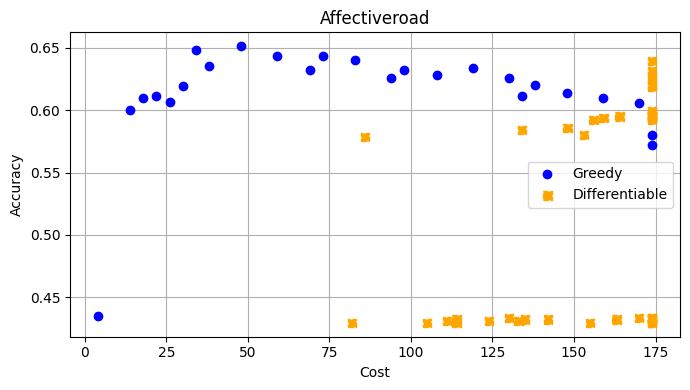

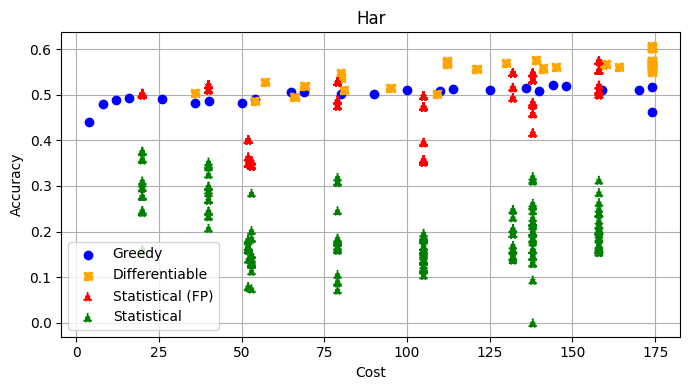

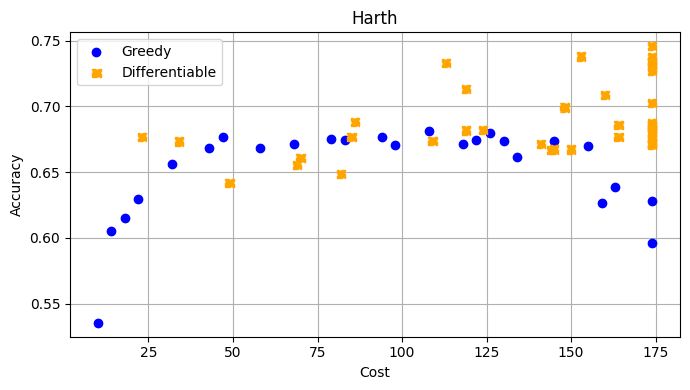

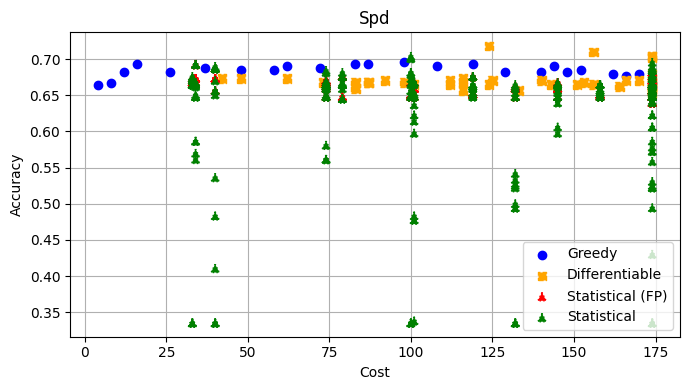

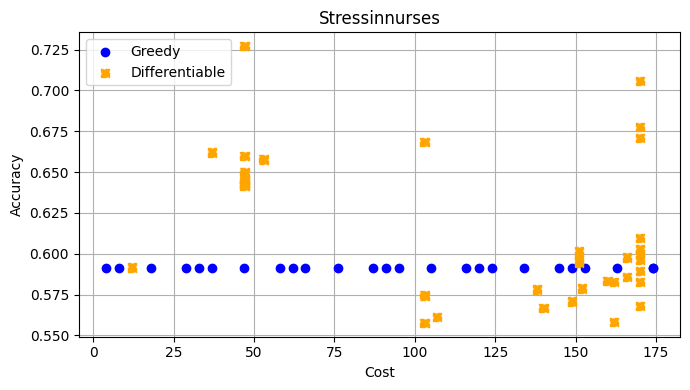

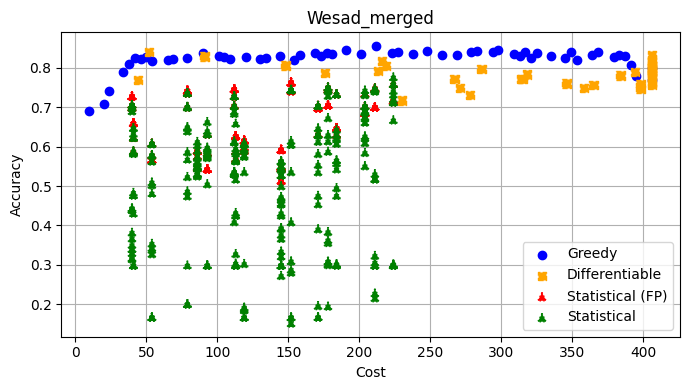

In [57]:
for dataset in diff_resdirs.keys():

    diff_resdir = diff_resdirs.get(dataset, None)
    if diff_resdir is None:
        diff_df = None
    else:
        diff_logfile = os.path.join(diff_resdir, os.path.basename(diff_resdir) + '.log')
        diff_df = parse_diff_logfile(diff_logfile)

    greedy_resdir = greedy_resdirs.get(dataset, None)
    if greedy_resdir is None:
        greedy_df = None
    else:
        greedy_resfile = os.path.join(greedy_resdir, 'greedy_selection_results.csv')
        greedy_df = pd.read_csv(greedy_resfile)

    statistical_resdir = statistical_resdirs.get(dataset, None)
    if statistical_resdir is None:
        statistical_df = None
    else:
        statistical_resfile = os.path.join(statistical_resdir, 'statistical_results.csv')
        statistical_df = pd.read_csv(statistical_resfile)

    plot_accuracy_vs_cost(greedy_df, diff_df, statistical_df, title=dataset.capitalize())

### Plot results from a single gates experiment

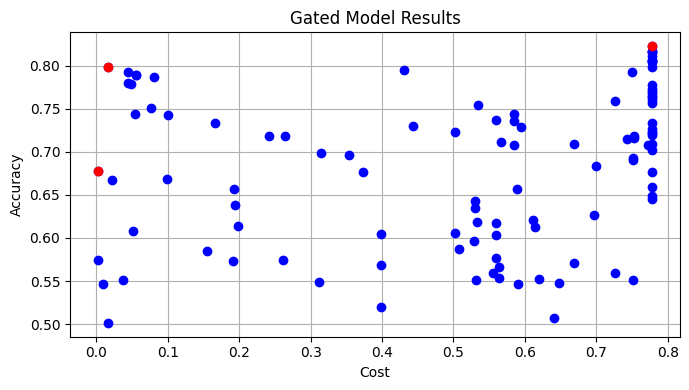

In [65]:
def filter_pareto_idxs_from_df(df, x_label, y_label):
    """Filters a pandas dataframe to keep only the non-dominated values"""
    x = df[x_label]
    y = df[y_label]
    # Initialize a list to store the indices of non-dominated points
    non_dominated_indices = []

    # Iterate through each point in the Series
    for i in range(len(x)):
        # Assume the current point is non-dominated
        dominated = False
        
        # Compare the current point with all other points
        for j in range(len(x)):
            if i != j:
                # Check if the other point dominates the current point
                if (x[j] <= x[i] and y[j] >= y[i]) and (x[j] < x[i] or y[j] > y[i]):
                    dominated = True
                    break

        # If the point is non-dominated, add its index to the list
        if not dominated:
            non_dominated_indices.append(i)

    # Filter the original Series to keep only non-dominated points
    non_dominated_values = df.iloc[non_dominated_indices].reset_index(drop=True)

    return non_dominated_indices, non_dominated_values


def plot_accuracy_vs_cost_from_csv(csvfile, title='Accuracy vs Cost'):
    df = pd.read_csv(csvfile)
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Plot the data
    ax.scatter(df['cost'], df['accuracy'], marker='o', label='Accuracy vs Cost', color='blue')
    # plot only the non-dominated points
    non_dominated_idxs, non_dominated_df = filter_pareto_idxs_from_df(df, 'cost', 'accuracy')
    ax.scatter(non_dominated_df['cost'], non_dominated_df['accuracy'], marker='o', label='Non-dominated', color='red')
    
    # Labels and legend
    ax.set_xlabel('Cost')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    # ax.legend()
    ax.grid(True)
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    return non_dominated_df


expdir = '/home/balaskas/flexaf/saved_logs/diff_fs_fcnn_wesad_merged___2025.08.06-16.16.48.524'
csvfile = os.path.join(expdir, 'results', 'gated_model_results.csv')
pareto_df = plot_accuracy_vs_cost_from_csv(csvfile, title='Gated Model Results')

In [70]:
pareto_df.iloc[0]['features']

'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]'

### Plot results from old gates diff experiment

In [ ]:

def plot_feature_selection_tradeoff(results_file):
    """Plot cost vs. accuracy for feature selection experiments."""
    df = pd.read_csv(results_file)

    if not {'method', 'accuracy', 'cost'}.issubset(df.columns):
        raise ValueError("CSV must contain 'method', 'accuracy', and 'cost' columns.")

    plt.figure(figsize=(8, 6))

    # Plot gate-tuned models
    df_gates = df[df['method'].str.contains('gates', case=False)]
    plt.scatter(df_gates['cost'], df_gates['accuracy'], label='With Gates', c='blue', alpha=0.7)

    # Plot baseline (no gates)
    df_baseline = df[df['method'] == 'no_gates_tuned']
    plt.scatter(df_baseline['cost'], df_baseline['accuracy'], label='No Gates (tuned)', c='red', s=100, edgecolors='black')

    # Labels and legend
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
    plt.title('Feature Selection: Accuracy vs. Cost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

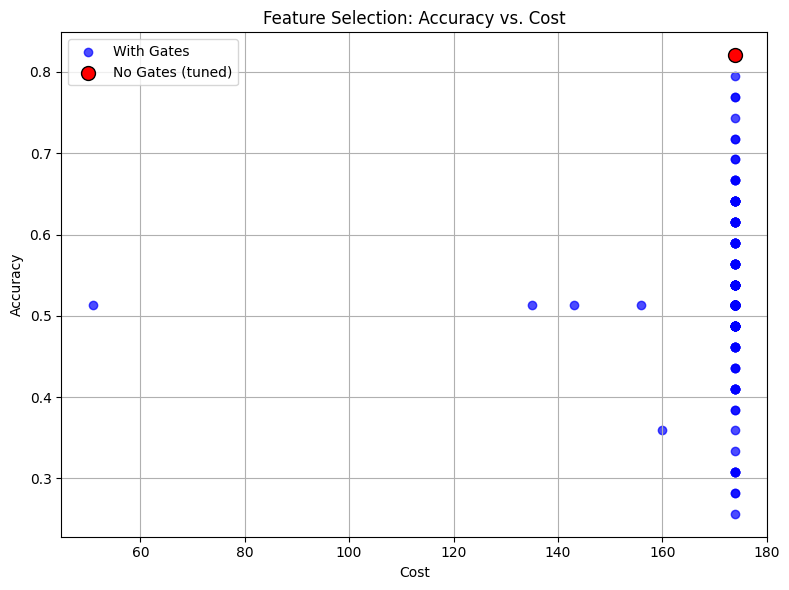

In [ ]:
results_file = os.path.join(project_dir, 'logs', 'concrete_test___2025.07.29-12.31.39.999', 'results.csv')
plot_feature_selection_tradeoff(results_file)